This notebook replicates the UNWISE X CIB analysis. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from galCIB import powerspectra as ps
from galCIB.clustering import gal
from galCIB import consts
from galCIB.clustering import cib 
from galCIB.clustering import halo 
from galCIB import precalc as pc 

/Users/tkarim/research/galCIB/src/galCIB/clustering/halo.py:105: DeprecationWarning: invalid escape sequence '\l'
  """
/Users/tkarim/research/galCIB/src/galCIB/clustering/halo.py:113: DeprecationWarning: invalid escape sequence '\i'
  """
/Users/tkarim/research/galCIB/src/galCIB/clustering/halo.py:124: DeprecationWarning: invalid escape sequence '\e'
  """
/Users/tkarim/research/galCIB/src/galCIB/clustering/halo.py:219: DeprecationWarning: invalid escape sequence '\D'
  """


ModuleNotFoundError: No module named 'galCIB.clustering.cosmology'

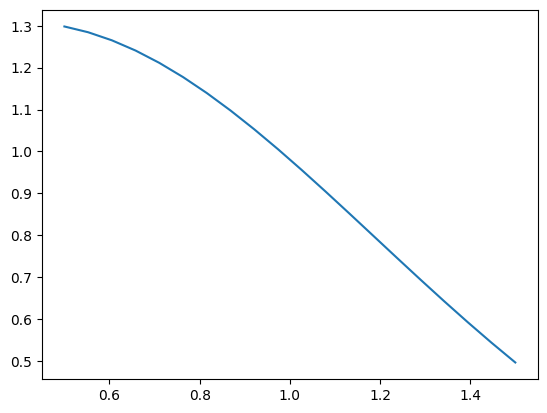

In [5]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

plt.plot(zs, pz)

In [6]:
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters

cib_filters = load_my_filters("/Users/tkarim/research/galCIB/data/filters/",
                nu_obs=nu_obs)

In [7]:
from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
NSIDE = 1024 
#mag_alpha = 2.225 
mag_alpha = 1 #FIXME: turn on mag bias 

unwise_survey = Survey(z=zs, 
                 pz=pz, mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE,
                 name="UNWISE-Planck")



In [8]:
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(unwise_survey.z, ks, Mh, colossus_cosmo_name='planck18',
                  use_little_h=False)

# Calculate window 
unwise_survey.compute_windows(cosmo,True)

wmu = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# Setup galaxy HOD

from galCIB import get_hod_model
unwise_hod_model = get_hod_model("Zheng05", cosmo)

In [10]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

theta_sat = np.array([0., 6.14, 1]) # no unfw
unwise_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='nfw')

In [11]:
from galCIB import SFRModel

# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)


In [13]:
from galCIB import SnuModel, SFRModel, CIBModel
theta_sfr_M21 = np.array([0.49, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR, cosmo=cosmo,
                     fsub=0.134)

# Non-parametric Snu model (M21)
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         nu_prime=np.array([353, 545, 857]))

# Initialize CIB model
cib_M21 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_M21,
                   hod_IR=hod_IR,
                   survey=unwise_survey,
                   cosmo=cosmo,
                   Nm_sub=198)

fsub = 0.134


In [14]:
cib_M21.update(theta_sfr=theta_sfr_M21,
               theta_snu=None,
               theta_hod_IR=theta_IR)

(100, 20)
set Ncen_IR = 1 for testing.
(198, 100, 20)


In [15]:
from galCIB import PkBuilder

# M21 
pk_survey_M21 = PkBuilder(cosmology=cosmo,
                      hod_model=unwise_hod_model,
                      cib_model=cib_M21,
                      prof_model=unwise_sat_profile
                      )

# compute pk
theta_cen = np.array([11.26, 2.43, 0.4]) # mu_min0, mu_minp, sigma_lnM
theta_sat = np.array([10**6, 12.5, 0.12, 1]) # mu_10, mu_1p, alpha_s
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr_M21 = np.array([0.49, #eta_max 
                      11.52,0, #mu0_peak, mup_peak
                      2.74,0.5,2.15]) #sigmaM0, tau, zc
theta_snu = None
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [16]:
# Pk predictions 
snu_models = ['M21']
pgg = {}
pII = {}
pgI = {}
pk_survey = {}
pk_survey['M21'] = pk_survey_M21

for snu in snu_models:
    print(snu)
    pgg[snu], pII[snu], pgI[snu] = pk_survey[snu].compute_pk(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=1)

M21
(100, 20)
set Ncen_IR = 1 for testing.
(198, 100, 20)


In [17]:
from galCIB import AnalysisModel

analysis = AnalysisModel(cosmology=cosmo,
                         survey=unwise_survey,
                         pk3d=pk_survey['M21'])


In [18]:
cgg, cgI, cII = analysis.update_cl(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr_M21,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=0.79)

(100, 20)
set Ncen_IR = 1 for testing.
(198, 100, 20)


In [4]:
# define fiducial values for M21 model

# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
hmalphas = 0.719*np.ones(10) 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.22, -1.24, -0.53])
shotnoise_gCIB = shotnoise_gCIB - 2 # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

In [19]:
# blue x 353

xb3 = np.array([148.97824653922214, 241.52933421226103, 342.3862887277521, 436.1239288068556, 526.3019116677654, 622.4126565589979, 711.4040870138431, 808.7013843111404, 904.8121292023731, 1005.6690837178642, 1092.28740936058, 1195.5174686882003, 1288.0685563612392, 1380.619644034278, 1479.10349373764, 1570.4680290046142, 1668.9518787079762, 1761.502966381015, 1854.054054054054, 1950.1647989452865])
yb3 = np.array([7.480594161973804, 7.797879010633586, 7.931587425151214, 8.047816419609008, 8.174340524488063, 8.223198986556294, 8.305764815715698, 8.402403589592033, 8.440781408547549, 8.4763626521893, 8.540487900410033, 8.584008849214815, 8.568976630590038, 8.65046451537871, 8.68388503262927, 8.677798985712526, 8.682363120858255, 8.69759424894262, 8.725077643799695, 8.737320345633321])

In [24]:
cgI[0]

array([0.06850246, 0.06791155, 0.0673307 , ..., 0.00093915, 0.00093867,
       0.00093818])

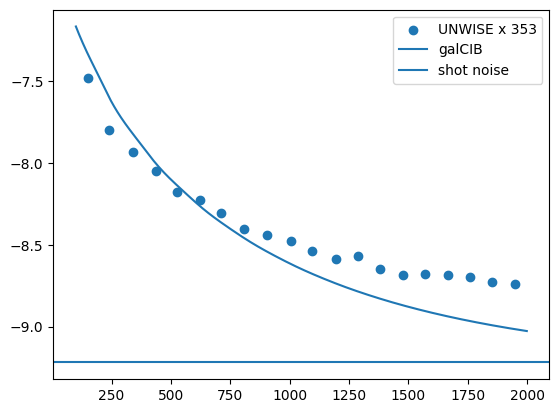

In [42]:

plt.scatter(xb3, -1*yb3,label = 'UNWISE x 353')
plt.plot(unwise_survey.ells,
         np.log10(cgI[0])-6, label = 'galCIB')

plt.axhline(-9.22, label = 'shot noise')
plt.legend(loc='best')

In [ ]:
log10(x/1e-8) = -1.22

In [ ]:
log10(x) + 8 = -1.22

In [31]:
cg353_int = np.interp(xb3, unwise_survey.ells,
                      np.log10(cgI[0])+0.2)

In [32]:
measure = (-1*yb3 + 6)
measure - cg353_int

array([-0.1516697 , -0.19544918, -0.10567493, -0.0465741 , -0.03775849,
        0.04019131,  0.05739438,  0.05664392,  0.10091368,  0.14142512,
        0.13529638,  0.15303843,  0.21690194,  0.17902871,  0.18715612,
        0.22774751,  0.25659845,  0.26956047,  0.2675414 ,  0.27916301])

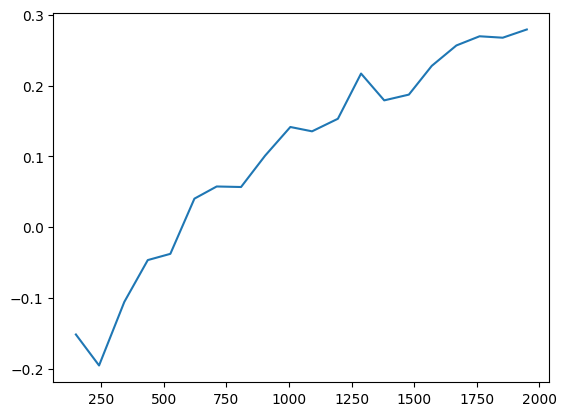

In [34]:
plt.plot(xb3, measure - cg353_int)

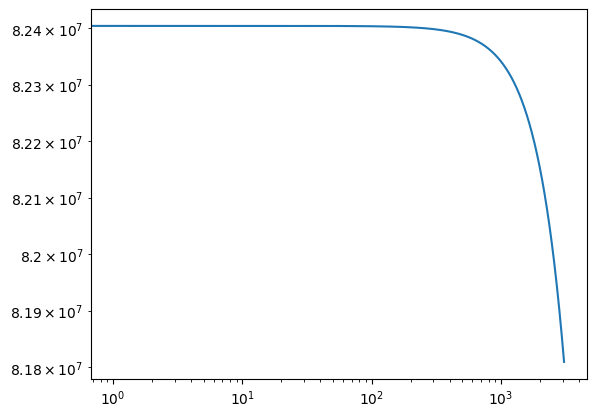

In [39]:
plt.loglog(ells, 
           c_all_k25_predict[0])

In [6]:
uprof = halo.uprof_mixed(prof_params, pc.rad200,
            pc.concentration, pc.concentration_amp,)
galterm, ncen, nsat = gal.galterm(gal_params, uprof,
            gal_type = 'UNWISE')
nbar_halo = gal.nbargal_halo(ncen, nsat, ps.hmfzT)

In [16]:
gg_pk_2h = ps.galcrossgal_pk_2h(galterm, nbar_halo)[0]
gg_pk_1h = ps.galcrossgal_pk_1h(galterm, nbar_halo,
                                ncen, nsat, uprof)

/Users/tkarim/research/galCIB/src/galCIB/powerspectra.py:63: RuntimeWarning: divide by zero encountered in log10
  ELL_sampled = np.logspace(np.log10(consts.LMIN),
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


In [8]:
gg_c_2h = ps.galcrossgal_cell_2h(galterm, nbar_halo)

In [15]:
uprof.shape

/Users/tkarim/research/galCIB/src/galCIB/powerspectra.py:63: RuntimeWarning: divide by zero encountered in log10
  ELL_sampled = np.logspace(np.log10(consts.LMIN),
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


(199, 100, 102)

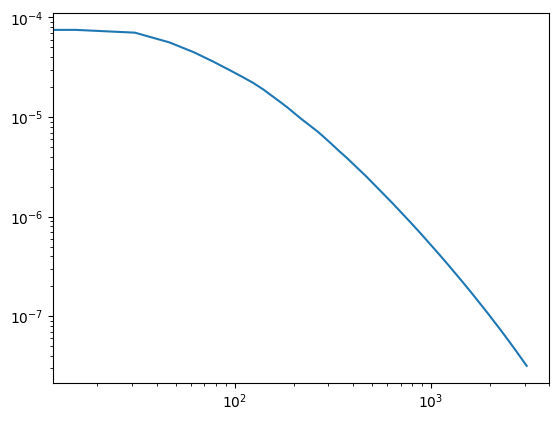

In [12]:
plt.loglog(consts.ell,
           gg_c_2h)

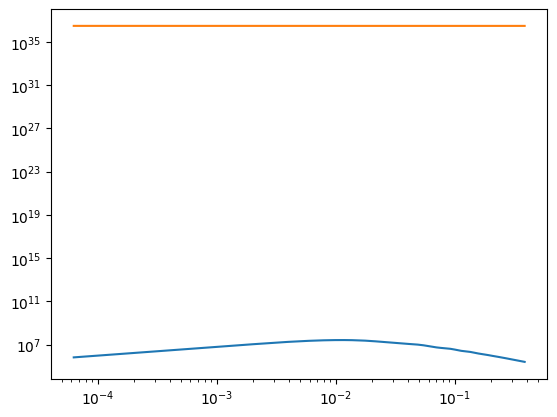

In [17]:
plt.loglog(consts.k_grid_over_ell[:,50],
           gg_pk_2h[:,50])

plt.loglog(consts.k_grid_over_ell[:,50],
           gg_pk_1h[:,50])

In [24]:
nsat

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [215.11443394, 210.24789863, 206.24519424, ..., 169.56754866,
        169.52883059, 169.49081562],
       [259.1060973 , 253.2443383 , 248.42306668, ..., 204.24471272,
        204.19807667, 204.1522875 ],
       [312.09421157, 305.03370209, 299.22646336, ..., 246.0134796 ,
        245.95730631, 245.9021531 ]])

# Produce with DopplerCIB

In [35]:
# DopplerCIB modules

import sys 
sys.path.append("//Users/tkarim/research/DopplerCIB/")

import CIB_halo as mcib
import cosmo_related as mcosmo
import input_var_cibmean as minput
import Gal_halo as mgh
import CIBxGal_halo as mcg
import hmf_unfw_bias as mhmf_unfw

In [36]:
## initialize cosmo_var_iv and data_var_iv to pass to DopplerCIB

cosmo_var = mcosmo.cosmo_var_iv(mass=consts.Mh_Msol,
                                z=consts.Plin['z'],
                                do_powerspec=1)

# experimental specification 

cib_exp = 'Planck'
# color corrections for 100, 143, 217, 353, 545, 857 and 3000 GHz for Planck
cc_pl = np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995])  # , 0.960])
cc = cc_pl  

nu0 = np.array([100., 143., 217., 353., 545., 857.]) 
nus = ['100', '143', '217', '353', '545', '857']
# fwhm obtained from https://wiki.cosmos.esa.int/planckpla/index.php/Effective_Beams
fwhm = np.array([9.651, 7.248, 4.990, 4.818, 4.682, 4.325])  # in arcmin
fwhm_rad = fwhm*(np.pi/180.)/60.
# fwhm = 4.8  # 4.8 Planck arcmin # 0.5 CCAT-Prime
# 1303.5067 for sensitivity (Tab:4 muK deg & kJy/sr deg)
sensitivity_muKarcmin = np.array([108., 48., 60., 210., 1137., 29075.])
sensitivity_Jy2_sr = np.array([58., 26.929, 72., 305, 369., 369.])
sensitivity_Jy_sr = np.sqrt(sensitivity_Jy2_sr)
# sensitivity = 13.5  # 13.5 Planck Jy/sr  # 1.2 CCAT-Prime
ell = np.logspace(2, np.log10(2000), 99)
fc = np.ones(len(nu0))

strfig = "allcomponents_lognormal_sigevol_1p5zcutoff_nolens_onlyautoshotpar_no3000_gaussian600n857n1200_planck_spire_hmflog10.txt"
cibres = "/Users/tkarim/research/galCIB/data/one_halo_bestfit_"+strfig

exp = {'name': cib_exp,
          'do_cibmean': 0,
          'cc': cc,
          'fc': fc,
          'snuaddr': '/Users/tkarim/research/galCIB/data/filtered_snu_planck.fits',
          # 'nu0min': nu0min, 'nu0max': nu0max,
          # 'nucen': str(int(nucen)),
          'nu0': nu0,
          'ell': ell,
          'fwhm': fwhm,
          'sensitivity': sensitivity_Jy_sr,
          'cibpar_resfile': cibres,
          'nu_string': nus}

## initialize data_var_iv 
data_var_iv = minput.data_var_iv(exp = exp)

Calculating the halo mass function for given mass and redshift for CIB mean calculations.
[39.52037275]
5.298428495800479e-17
2.4832862197860225e-18


In [ ]:
gal_obj_m21 = mgh.ProfHODMore15(data_var_iv, cosmo_var, 
                                gal_exp='DESI_ELG')